#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using using swim data

version 1.0 2021-05-05

In [1]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from mizani.formatters import date_format
from patsy import dmatrices
from plotnine import *
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


### Read data

In [2]:
daily_agg = pd.read_csv("/workspaces/codespaces-jupyter/data/swim_work.csv", parse_dates=["date"])
#daily_agg = pd.read_csv("https://osf.io/download/jcxmk/", parse_dates=["date"])

In [3]:
daily_agg.head()

,date,QUANTITY
0,2010-01-01,0
1,2010-01-02,49
2,2010-01-03,31
3,2010-01-04,14
4,2010-01-05,18


In [4]:
daily_agg["year"] = daily_agg["date"].dt.year
daily_agg["quarter"] = daily_agg["date"].dt.quarter
daily_agg["month"] = daily_agg["date"].dt.month
daily_agg["day"] = daily_agg["date"].dt.day
daily_agg["dow"] = daily_agg["date"].dt.dayofweek + 1
daily_agg["weekend"] = daily_agg["dow"].isin([6, 7])


In [5]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend
0,2010-01-01,0,2010,1,1,1,5,False
1,2010-01-02,49,2010,1,1,2,6,True
2,2010-01-03,31,2010,1,1,3,7,True
3,2010-01-04,14,2010,1,1,4,1,False
4,2010-01-05,18,2010,1,1,5,2,False
...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False
2553,2016-12-28,17,2016,4,12,28,3,False
2554,2016-12-29,27,2016,4,12,29,4,False
2555,2016-12-30,3,2016,4,12,30,5,False


In [6]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [7]:
daily_agg["trend"] = daily_agg.index + 1

In [8]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend
0,2010-01-01,0,2010,1,1,1,5,False,False,1
1,2010-01-02,49,2010,1,1,2,6,True,False,2
2,2010-01-03,31,2010,1,1,3,7,True,False,3
3,2010-01-04,14,2010,1,1,4,1,False,False,4
4,2010-01-05,18,2010,1,1,5,2,False,False,5
...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556


### Holiday Calendar

In [ ]:
nyse = mcal.get_calendar("NYSE")
holidays = nyse.holidays().holidays
daily_agg["isHoliday"] = daily_agg["date"].isin(holidays)

In [10]:
most_recent_holiday = max(holiday for holiday in holidays if holiday <= np.datetime64('today'))
most_recent_holiday

numpy.datetime64('2025-07-04')

In [13]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False
...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False


In [15]:
daily_agg.describe(include='all')

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557,2557,2557.000000,2557
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1826,1850,NaN,2493
mean,2013-07-02 00:00:00,47.867032,2013.000782,2.508408,6.522487,15.730935,4.001173,NaN,NaN,1279.000000,NaN
min,2010-01-01 00:00:00,0.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN
25%,2011-10-02 00:00:00,14.000000,2011.000000,2.000000,4.000000,8.000000,2.000000,NaN,NaN,640.000000,NaN
50%,2013-07-02 00:00:00,28.000000,2013.000000,3.000000,7.000000,16.000000,4.000000,NaN,NaN,1279.000000,NaN
75%,2015-04-02 00:00:00,64.000000,2015.000000,4.000000,10.000000,23.000000,6.000000,NaN,NaN,1918.000000,NaN
max,2016-12-31 00:00:00,287.000000,2016.000000,4.000000,12.000000,31.000000,7.000000,NaN,NaN,2557.000000,NaN


### Define vars for analysis

In [16]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["QUANTITY2"] = np.where(daily_agg["QUANTITY"] < 1, 1, daily_agg["QUANTITY"])

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY2"])

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]

daily_agg


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False,21.271889,49,3.891820,36.312500,3.443075,Sat,Jan
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False,21.271889,31,3.433987,39.343750,3.519238,Sun,Jan
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False,21.271889,14,2.639057,16.900000,2.726322,Mon,Jan
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False,21.271889,18,2.890372,16.800000,2.675239,Tue,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec


In [17]:
daily_agg["year"].value_counts()

year
2012    366
2016    366
2010    365
2011    365
2013    365
2014    365
2015    365
Name: count, dtype: int64

## Prediction

### Creat train/holdout data

In [19]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]
daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")

data_holdout = daily_agg.loc[daily_agg["year"] == 2016, :]

data_train = daily_agg.loc[daily_agg["year"] < 2016, :]


In [20]:
factor_cols

['month', 'dow', 'isHoliday', 'school_off']

In [24]:
data_train.tail()


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb,months_order,days_order
2186,2015-12-27,0,2015,4,12,27,7,True,True,2187,False,15.97235,1,0.000000,25.266667,2.927724,Sun,Dec,Dec,Sun
2187,2015-12-28,16,2015,4,12,28,1,False,True,2188,False,15.97235,16,2.772589,13.483871,2.392609,Mon,Dec,Dec,Mon
2188,2015-12-29,32,2015,4,12,29,2,False,True,2189,False,15.97235,32,3.465736,14.612903,2.507322,Tue,Dec,Dec,Tue
2189,2015-12-30,15,2015,4,12,30,3,False,True,2190,False,15.97235,15,2.708050,14.903226,2.470384,Wed,Dec,Dec,Wed
2190,2015-12-31,16,2015,4,12,31,4,False,True,2191,False,15.97235,16,2.772589,13.093750,2.321463,Thu,Dec,Dec,Thu


In [25]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:, "year"].to_numpy()

In [26]:
data_train.loc[:, "year"].unique()

array([2010, 2011, 2012, 2013, 2014, 2015], dtype=int32)

In [27]:
lin_reg = LinearRegression(fit_intercept=False)

In [28]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(root_mean_squared_error(y_test, y_hat))

    return np.mean(rmse_folds)

In [29]:
# Model 1 linear trend + monthly seasonality

y, X = dmatrices("QUANTITY ~ 1 + trend + month", data_train)

rmse_reg1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg1


np.float64(32.347871356433025)

In [30]:
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [[ 2.04544321e+01 -2.12370205e-01  1.56316311e+01  1.48743719e+01
   3.90082955e+01  1.24600714e+02  9.23656050e+01  4.09917153e+01
   1.18929479e+00 -3.48323323e+00 -6.63103008e+00 -6.34527853e+00
   1.86324921e-03]]
Intercept: 0.0


In [31]:
# Model 2 linear trend + monthly seasonality + days of week seasonality

y, X = dmatrices("QUANTITY ~ 1+ trend + month + dow", data_train)

rmse_reg2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg2

np.float64(31.448481901741218)

In [32]:
# Model 3 linear trend + monthly seasonality + days of week  seasonality + holidays

y, X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday", data_train)

rmse_reg3 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg3

np.float64(31.458263026080612)

In [33]:
# Model 4 linear trend + monthly seasonality + days of week  seasonality + holidays + sch*dow

y, X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow", data_train)

rmse_reg4 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg4

np.float64(27.604745017684753)

In [34]:
# Model 5 linear trend + monthly seasonality + days of week  seasonality + holidays + interactions

y, X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month", data_train)

rmse_reg5 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg5 


np.float64(26.904121178171383)

In [35]:
data_train2 = data_train.loc[lambda x: x.QUANTITY >= 1]
groups = data_train2.loc[:, "year"].to_numpy()

In [36]:
y, X = dmatrices("q_ln ~ 1 + trend + month + dow + school_off*dow", data_train2)

rmse_folds2 = []
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lin_reg.fit(X_train, y_train)
    y_hat = lin_reg.predict(X)
    corrb = mean_squared_error(y, y_hat)
    y_hat = np.exp((lin_reg.predict(X_test) + corrb / 2))
    rmse_folds2.append(root_mean_squared_error(y_test, y_hat))
# NOTE: this is different from book -- TODO: check why

rmse_reg6 = np.mean(rmse_folds2)
rmse_reg6

np.float64(69.93103240681785)

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
import numpy as np
import patsy as pt

logo = GroupKFold(n_splits=5)
lin = LinearRegression(fit_intercept=False)

y_log, X = pt.dmatrices("q_ln ~ 1 + trend + month + dow + school_off*dow", data_train2)
y_log = np.ravel(y_log)
y_level = np.exp(y_log)  # level truth

rmse_folds = []
for tr, te in logo.split(X, y_log, groups):
    # fit on TRAIN (log scale)
    lin.fit(X[tr], y_log[tr])
    # training residual variance on log scale
    yhat_log_tr = lin.predict(X[tr])
    sigma2 = np.mean((y_log[tr] - yhat_log_tr)**2)

    # predict TEST, back-transform with bias correction
    yhat_log_te = lin.predict(X[te])
    yhat_level_te = np.exp(yhat_log_te + 0.5*sigma2)

    # compare on the LEVEL
    rmse_folds.append(np.sqrt(mean_squared_error(y_level[te], yhat_level_te)))

rmse_reg6= np.mean(rmse_folds)
print(rmse_reg6)

30.866679086493633


In [38]:
# Use prophet prediction -------------------------------------------
# add CV into prophet
# can be done with prophet: https://facebook.github.io/prophet/docs/diagnostics.html
# done but this is a different cross-validation as for the other models as it must be time-series like

# prophet -  multiplicative option -- tried but produced much worse results (~34. RMSE)

# Install the prophet package
%pip install prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet, "US")


In [40]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train[["date", "QUANTITY"]].rename({"date": "ds", "QUANTITY": "y"}, axis=1),
)

23:55:11 - cmdstanpy - INFO - Chain [1] start processing
23:55:11 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
cv_pred = cross_validation(
    model_prophet, initial="365 days", period="365 days", horizon="365 days"
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/5 [00:00<?, ?it/s]

23:55:11 - cmdstanpy - INFO - Chain [1] start processing
23:55:11 - cmdstanpy - INFO - Chain [1] done processing
23:55:11 - cmdstanpy - INFO - Chain [1] start processing
23:55:11 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing
23:55:12 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing
23:55:12 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing
23:55:12 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
rmse_prophet_cv = performance_metrics(cv_pred, rolling_window=1)["rmse"].values[0]
rmse_prophet_cv

np.float64(29.46234963418531)

In [43]:
# Note: M6 log model rmse is slightly different from book
pd.DataFrame(
    [rmse_reg1, rmse_reg2, rmse_reg3, rmse_reg4, rmse_reg5, rmse_reg6, rmse_prophet_cv],
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(2)


,RMSE
M1,32.35
M2,31.45
M3,31.46
M4,27.60
M5,26.90
M6 (log),30.87
M7 (Prophet),29.46


## Evaluate best model on holdout set

In [65]:
data_train["dow"]

0       5
1       6
2       7
3       1
4       2
       ..
2186    7
2187    1
2188    2
2189    3
2190    4
Name: dow, Length: 2191, dtype: category
Categories (7, int32): [1, 2, 3, 4, 5, 6, 7]

In [44]:
lin_reg = LinearRegression(fit_intercept=False)

y, X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month", data_train,)
lin_reg.fit(X, y) # fitting 

_, X_holdout = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month", data_holdout,)
data_holdout["y_hat_5"] = lin_reg.predict(X_holdout) # prediction 


/tmp/ipykernel_1812/310284632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
data_holdout

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,...,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb,months_order,days_order,y_hat_5
2191,2016-01-01,0,2016,1,1,1,5,False,False,2192,...,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan,Jan,Fri,2.988720
2192,2016-01-02,16,2016,1,1,2,6,True,False,2193,...,21.271889,16,2.772589,36.312500,3.443075,Sat,Jan,Jan,Sat,37.666521
2193,2016-01-03,32,2016,1,1,3,7,True,False,2194,...,21.271889,32,3.465736,39.343750,3.519238,Sun,Jan,Jan,Sun,36.833618
2194,2016-01-04,19,2016,1,1,4,1,False,False,2195,...,21.271889,19,2.944439,16.900000,2.726322,Mon,Jan,Jan,Mon,18.130956
2195,2016-01-05,14,2016,1,1,5,2,False,False,2196,...,21.271889,14,2.639057,16.800000,2.675239,Tue,Jan,Jan,Tue,18.557431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,...,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec,Dec,Tue,49.914491
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,...,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec,Dec,Wed,46.876008
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,...,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec,Dec,Thu,38.852609
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,...,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec,Dec,Fri,20.828419


In [46]:
mse_holdout_best = mean_squared_error(data_holdout.QUANTITY, data_holdout.y_hat_5)
rmse_holdout_best = np.sqrt(mse_holdout_best)
rmse_holdout_best

np.float64(24.57749617556061)

### Plot best predictions

In [47]:
# graph relative RMSE (on holdout) per month

group = data_holdout.sort_values(by=["date"]).groupby("month")
rmse_monthly = pd.DataFrame(
    {
        "date": group["date"].first(),
        "RMSE": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_5"]))
        ),
        "RMSE_norm": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_5"]))
            / np.mean(x["QUANTITY"])
        ),
    }
).reset_index(drop=True)


/tmp/ipykernel_1812/3658084438.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_1812/3658084438.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_1812/3658084438.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

In [48]:
rmse_monthly 

,date,RMSE,RMSE_norm
0,2016-01-01,11.005027,0.488762
1,2016-02-01,11.957508,0.432919
2,2016-03-01,18.922753,0.583687
3,2016-04-01,19.240643,0.483838
4,2016-05-01,46.147764,0.745094
5,2016-06-01,33.408433,0.254702
6,2016-07-01,31.585540,0.258693
7,2016-08-01,32.047353,0.590647
8,2016-09-01,12.944442,0.487856
9,2016-10-01,17.006909,0.701083


### Figure 18.7 b)

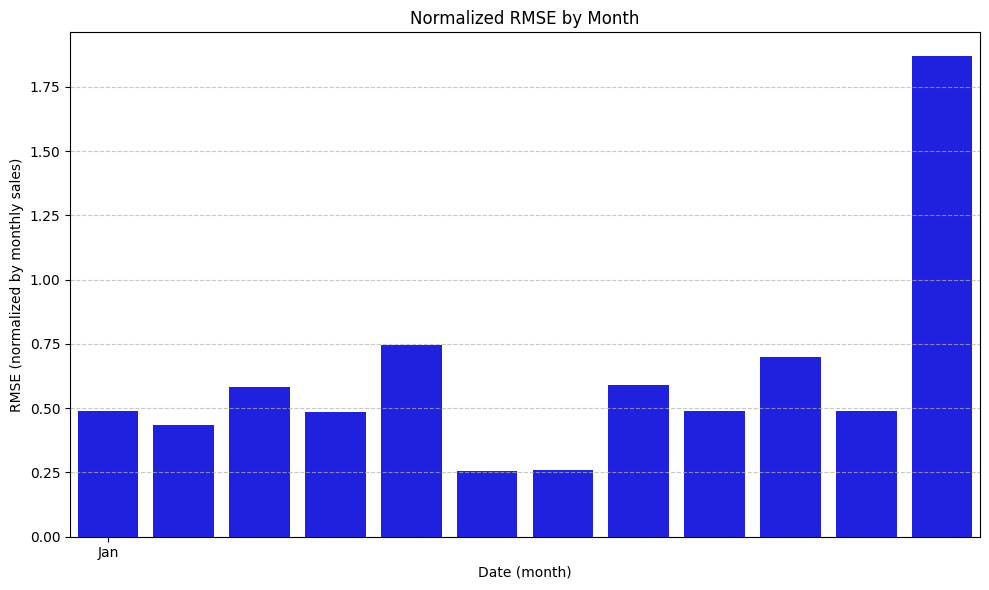

In [51]:
# Assuming `rmse_monthly` is a DataFrame with columns "date" and "RMSE_norm"
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(data=rmse_monthly, x="date", y="RMSE_norm", color="blue")

# Format the x-axis to display month abbreviations
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("RMSE (normalized by monthly sales)")
plt.title("Normalized RMSE by Month")

# Apply a grid and show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
rmse_monthly

,date,RMSE,RMSE_norm
0,2016-01-01,11.005027,0.488762
1,2016-02-01,11.957508,0.432919
2,2016-03-01,18.922753,0.583687
3,2016-04-01,19.240643,0.483838
4,2016-05-01,46.147764,0.745094
5,2016-06-01,33.408433,0.254702
6,2016-07-01,31.585540,0.258693
7,2016-08-01,32.047353,0.590647
8,2016-09-01,12.944442,0.487856
9,2016-10-01,17.006909,0.701083


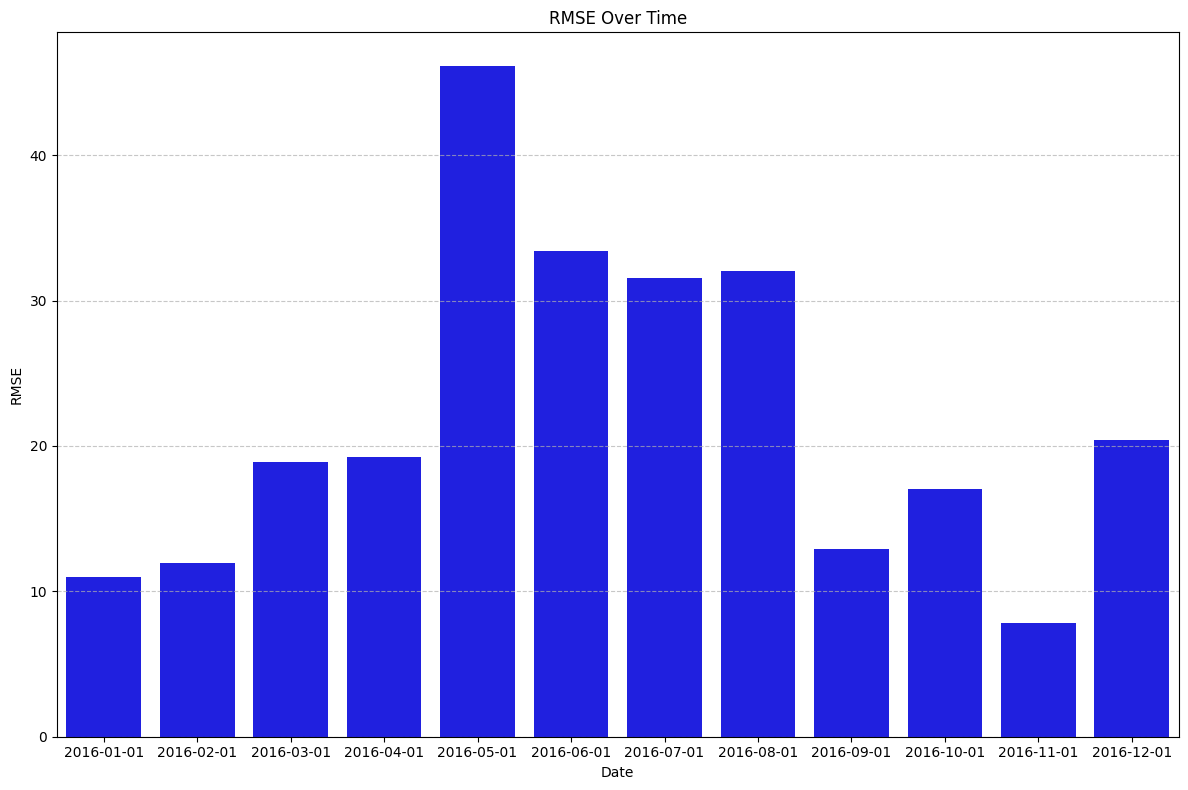

In [53]:
plt.figure(figsize=(12, 8))
sns.barplot(data=rmse_monthly, x="date", y="RMSE", color="blue")
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.title("RMSE Over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
plotdata = (
    data_holdout.filter(["date", "month", "QUANTITY", "y_hat_5"])
    .melt(id_vars=["date", "month"])
    .merge(data_holdout.filter(["date", "QUANTITY"]), on="date")
    .merge(data_holdout.filter(["date", "y_hat_5"]), on="date")
    .rename(columns={"QUANTITY": "ymin", "y_hat_5": "ymax"})
)

In [55]:
plotdata

,date,month,variable,value,ymin,ymax
0,2016-01-01,1,QUANTITY,0.000000,0,2.988720
1,2016-01-02,1,QUANTITY,16.000000,16,37.666521
2,2016-01-03,1,QUANTITY,32.000000,32,36.833618
3,2016-01-04,1,QUANTITY,19.000000,19,18.130956
4,2016-01-05,1,QUANTITY,14.000000,14,18.557431
...,...,...,...,...,...,...
727,2016-12-27,12,y_hat_5,49.914491,12,49.914491
728,2016-12-28,12,y_hat_5,46.876008,17,46.876008
729,2016-12-29,12,y_hat_5,38.852609,27,38.852609
730,2016-12-30,12,y_hat_5,20.828419,3,20.828419


### Figure 18.6

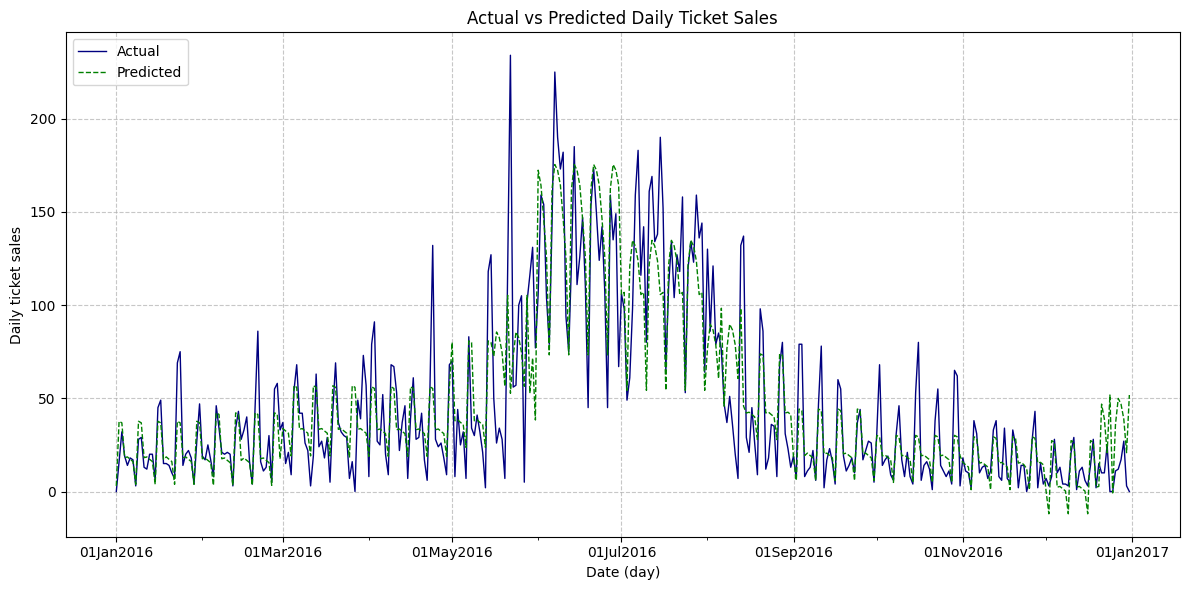

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'variable' column contains the expected values
plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'QUANTITY'],
    x='date',
    y='value',
    label='Actual',
    color='navy',
    linestyle='-',
    linewidth=1
)
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'y_hat_5'],
    x='date',
    y='value',
    label='Predicted',
    color='green',
    linestyle='--',
    linewidth=1
)
    
    # Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b%Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    # Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Actual vs Predicted Daily Ticket Sales")
plt.legend(loc="upper left")
    
    # Add grid
plt.grid(True, linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
plt.tight_layout()
plt.show()


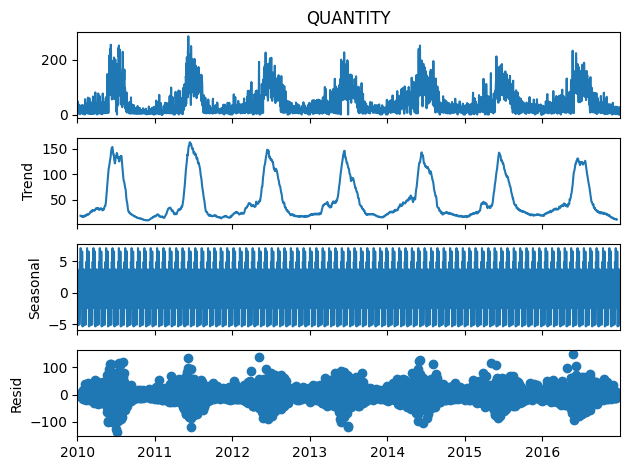

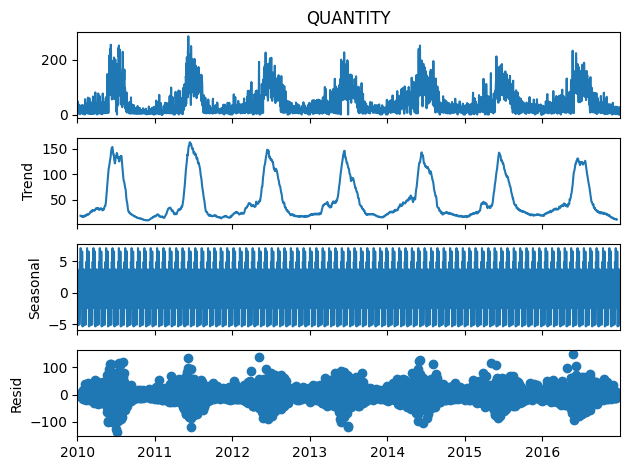

In [59]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# make sure date is datetime and set as index
daily_agg["date"] = pd.to_datetime(daily_agg["date"])
daily_agg = daily_agg.set_index("date")

# extract the series we want to analyze
series = daily_agg["QUANTITY"]

# decompose with monthly seasonality (period = 12 for monthly data)
decomp = seasonal_decompose(series, model="additive", period=30)  # 30 days ~ monthly
decomp.plot()

### Figure 18.7 a)

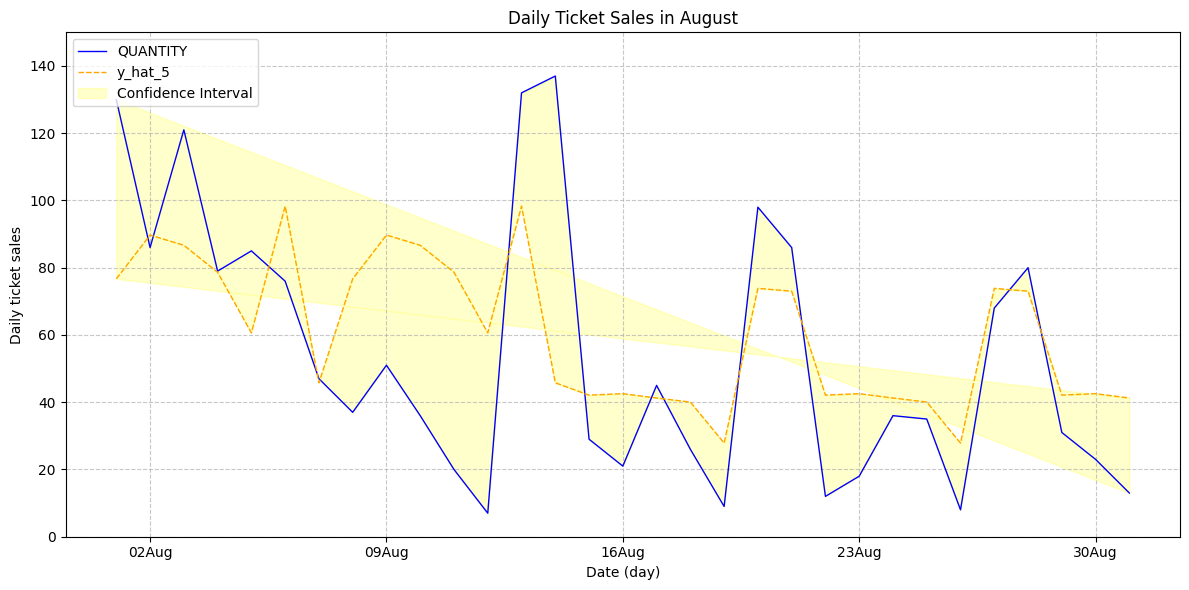

In [60]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for August
august_data = plotdata.loc[lambda x: x["month"] == 8].reset_index()

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
sns.lineplot(
    data=august_data,
    x="date",
    y="value",
    hue="variable",
    style="variable",
    palette={"QUANTITY": "blue", "y_hat_5": "orange"},
    linewidth=1,
)

# Add ribbon for ymin and ymax
plt.fill_between(
    august_data["date"],
    august_data["ymin"],
    august_data["ymax"],
    color="yellow",
    alpha=0.2,
    label="Confidence Interval",
)

# Format the y-axis and x-axis
plt.ylim(0, 150)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Daily Ticket Sales in August")
plt.legend(loc="upper left")

# Apply grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()